In [2]:
import datetime
import pandas as pd
import numpy as np

#data = pd.read_csv('C:\\temp\\sizing\\data.csv')
data = pd.read_csv('data.csv')
data['Date'] = pd.to_datetime(data['Date'])
data['StartDate'] = pd.to_datetime(data['StartDate'])
data['EndDate'] = pd.to_datetime(data['EndDate'])

# RosterCode, Date, StartDate, EndDate, Tickets, TicketsPrev, Persons

from IPython.display import display, HTML
display(HTML('<h1>Predicting Sizing using a Random Forest Regressor</h1></br/>'))

table = '<table>' \
            '<tr>' \
                '<td style="text-align: left">Tickets</td>' \
                '<td style="text-align: left">clientes reais</td>' \
            '</tr>' \
            '<tr>' \
                '<td style="text-align: left">TicketsPrev</td>' \
                '<td style="text-align: left">clientes estimados</td>' \
            '</tr>' \
            '<tr>' \
                '<td style="text-align: left">Persons</td>' \
                '<td style="text-align: left">pessoas em caixa estimadas a partir de TicketsPrev</td>' \
            '</tr>' \
            '<tr>' \
                '<td style="text-align: left">Articles</td>' \
                '<td style="text-align: left">artigos vendidos reais</td>' \
            '</tr>' \
            '<tr>' \
                '<td style="text-align: left">ArticlesPrev</td>' \
                '<td style="text-align: left">artigos vendidos estimados</td>' \
            '</tr>' \
            '<tr>' \
                '<td style="text-align: left">Checkouts</td>' \
                '<td style="text-align: left">caixas que venderam artigos</td>' \
            '</tr>' \
        '</table>'

display(HTML(table))

data

Tickets,clientes reais
TicketsPrev,clientes estimados
Persons,pessoas em caixa estimadas a partir de TicketsPrev
Articles,artigos vendidos reais
ArticlesPrev,artigos vendidos estimados
Checkouts,caixas que venderam artigos


,RosterCode,Date,StartDate,EndDate,Tickets,TicketsPrev,Persons,Articles,ArticlesPrev,Checkouts
0,10,2021-11-01,2021-11-01 09:00:00,2021-11-01 10:00:00,32,55,2,77,309,1
1,10,2021-11-01,2021-11-01 10:00:00,2021-11-01 11:00:00,57,69,3,121,440,1
2,10,2021-11-01,2021-11-01 11:00:00,2021-11-01 12:00:00,87,112,4,175,643,1
3,10,2021-11-01,2021-11-01 12:00:00,2021-11-01 13:00:00,97,118,4,186,643,1
4,10,2021-11-01,2021-11-01 13:00:00,2021-11-01 14:00:00,100,130,4,194,791,1
...,...,...,...,...,...,...,...,...,...,...
207478,75,2022-10-31,2022-10-31 17:00:00,2022-10-31 18:00:00,52,38,2,272,189,3
207479,75,2022-10-31,2022-10-31 18:00:00,2022-10-31 19:00:00,122,66,3,727,462,4
207480,75,2022-10-31,2022-10-31 19:00:00,2022-10-31 20:00:00,125,92,3,703,453,4
207481,75,2022-10-31,2022-10-31 20:00:00,2022-10-31 21:00:00,114,70,3,658,368,4


In [3]:
data_filtered = data.drop(columns=['Date', 'EndDate', 'TicketsPrev', 'Persons' , 'Articles', 'ArticlesPrev'])
display(HTML('<h1>Initial Data Filter</h1>'))
data_filtered

,RosterCode,StartDate,Tickets,Checkouts
0,10,2021-11-01 09:00:00,32,1
1,10,2021-11-01 10:00:00,57,1
2,10,2021-11-01 11:00:00,87,1
3,10,2021-11-01 12:00:00,97,1
4,10,2021-11-01 13:00:00,100,1
...,...,...,...,...
207478,75,2022-10-31 17:00:00,52,3
207479,75,2022-10-31 18:00:00,122,4
207480,75,2022-10-31 19:00:00,125,4
207481,75,2022-10-31 20:00:00,114,4


In [4]:
class PrintTable:
    def __init__(self, values, captions, widths, aligns):
        if not all([len(values[0]) == len(x) for x in [captions, widths, aligns]]):
            raise Exception()

        self._tablewidth = sum(widths) + 3*(len(captions)-1) + 4
        self._values = values
        self._captions = captions
        self._widths = widths
        self._aligns = aligns

    def print(self):
        self._printTable()

    def _printTable(self):
        formattext_head = ""
        formattext_cell = ""
        
        for i, v in enumerate(self._widths):
            formattext_head += "{" + str(i) + ":^" + str(v) + "} | "
            formattext_cell += "{" + str(i) + ":" + self._aligns[i] + str(v) + "} | "
            
        formattext_head = formattext_head[:-3]
        formattext_head = "  " + formattext_head.strip() + "  "
        formattext_cell = formattext_cell[:-3]
        formattext_cell = "  " + formattext_cell.strip() + "  "

        print("-"*self._tablewidth)
        print(formattext_head.format(*self._captions))
        print("-"*self._tablewidth)
        
        for w in self._values:
            print(formattext_cell.format(*w))
            
        print("-"*self._tablewidth)    

---------------------------------------------------------------------
Nº stores: 52
---------------------------------------------------------------------

----------------------------------------------------------------------------------------------------------------
Store 10
----------------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------
     Mean    |   Median   |    Mode    |      Quantiles       | Min Value  | Max Value   
-----------------------------------------------------------------------------------------
      3      |     4      |     4      |   [3.0, 4.0, 4.0]    |     1      |     4       
-----------------------------------------------------------------------------------------


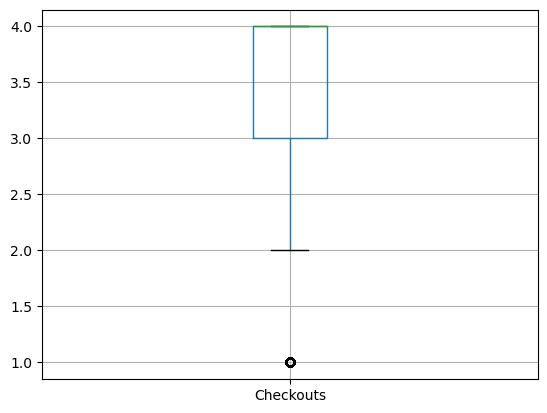

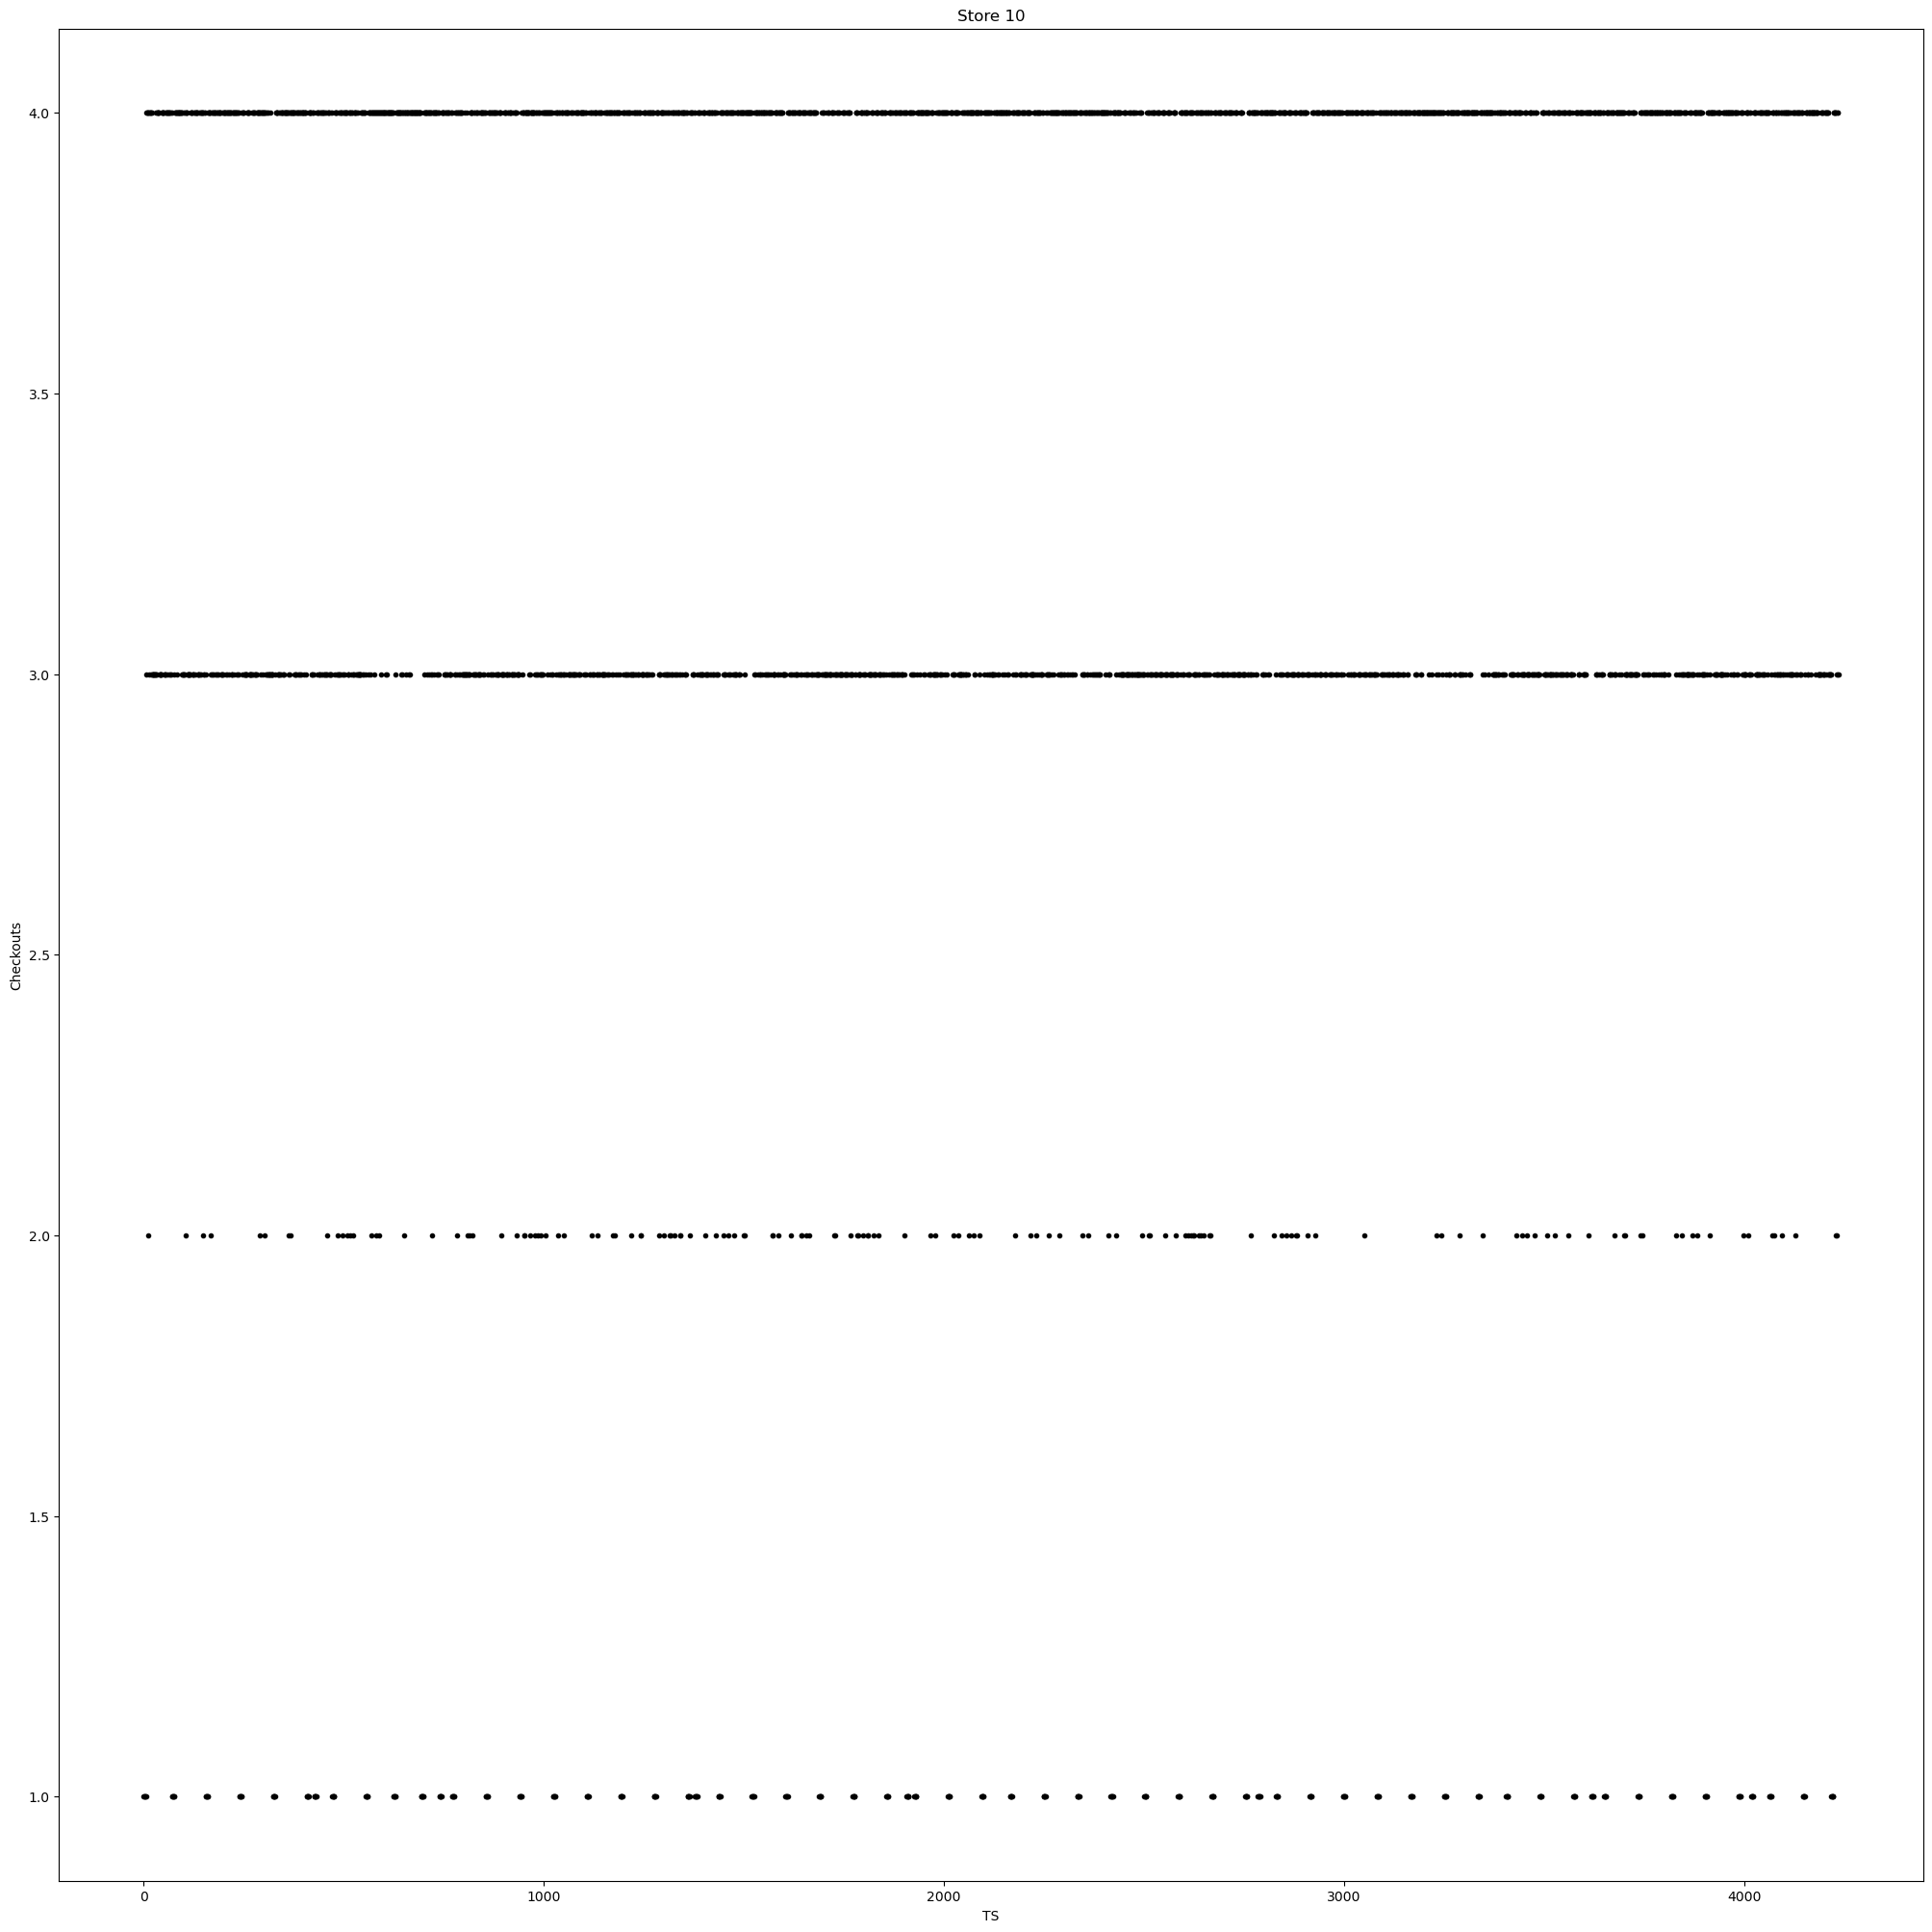

> 1: real: 2  estimated: 4
> 1: real: 2  estimated: 4
> 1: real: 2  estimated: 4
< 1: real: 4  estimated: 2
< 1: real: 4  estimated: 2
> 1: real: 2  estimated: 4
> 1: real: 1  estimated: 3
> 1: real: 2  estimated: 4


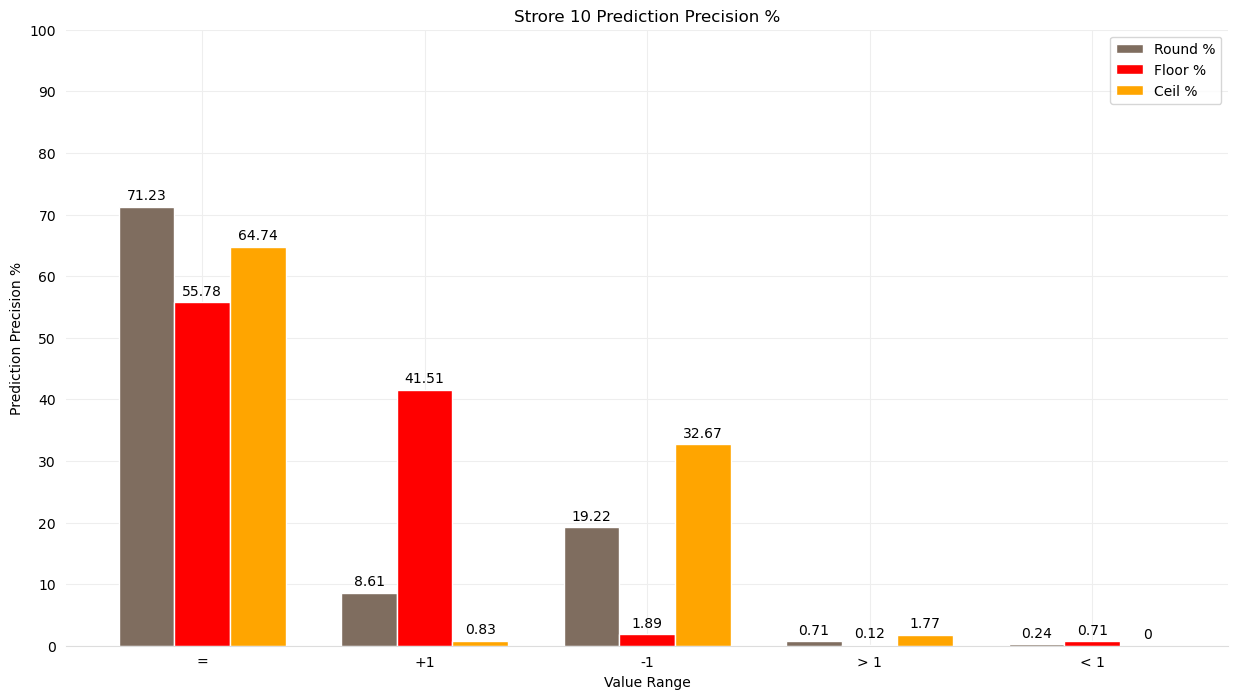

-----------------------------------------------------------------------------------------
         Method        |     =      |     +1     |     -1     |    > 1     |    < 1      
-----------------------------------------------------------------------------------------
  Round                |        604 |         73 |        163 |          6 |          2  
  Floor                |        473 |        352 |         16 |          1 |          6  
  Ceil                 |        549 |          7 |        277 |         15 |          0  
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
         Method        |     =      |     +1     |     -1     |    > 1     |    < 1      
-----------------------------------------------------------------------------------------
  Round %              |      71.23 |       8.61 |      19.22 |       0.71 |       0.24  
  Floor % 

,Store ID,N Records,N Records Agg,N Records Train,N Records Test,RAW MAE,ROUND MAE,FLOOR MAE,CEIL MAE
0,10.0,4237.0,4237.0,3389.0,848.0,0.321926,0.29717,0.450472,0.371462


,ROUND =,ROUND +1,ROUND -1,ROUND > 1,ROUND < 1,FLOOR =,FLOOR +1,FLOOR -1,FLOOR > 1,FLOOR < 1,CEIL =,CEIL +1,CEIL -1,CEIL > 1,CEIL < 1
0,71.23,8.61,19.22,0.71,0.24,55.78,41.51,1.89,0.12,0.71,64.74,0.83,32.67,1.77,0.0


In [9]:
stores = pd.value_counts(data_filtered['RosterCode'].values.ravel())
stores_ids = list(stores.index)
stores_ids.sort()

#print(stores)
#print(stores_ids)
#print(stores.array)

print('---------------------------------------------------------------------')
print('Nº stores: ' + str(len(stores)))
print('---------------------------------------------------------------------')

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt, ceil, floor
from matplotlib import pyplot
from statistics import mean, median, mode, quantiles
#import tabletext

"""
def model_metrics(y_true, y_pred):
    d_metrics = {}
    d_metrics['mse'] = np.sqrt(mean_squared_error(y_true, y_pred))
    d_metrics['mae'] = mean_absolute_error(y_true, y_pred)
    d_metrics['r2_score'] = r2_score(y_true, y_pred)
    
    return d_metrics
"""

d = {  'ROUND =': []
     , 'ROUND +1': []
     , 'ROUND -1': []
     , 'ROUND > 1': []
     , 'ROUND < 1': []
     , 'FLOOR =': []
     , 'FLOOR +1': []
     , 'FLOOR -1': []
     , 'FLOOR > 1': []
     , 'FLOOR < 1': []     
     , 'CEIL =': []
     , 'CEIL +1': []
     , 'CEIL -1': []
     , 'CEIL > 1': []
     , 'CEIL < 1': []}
    
r_pred_prec = pd.DataFrame(data=d)

d = {  'Store ID': []
     , 'N Records': []
     , 'N Records Agg': []
     , 'N Records Train': []
     , 'N Records Test': []
     , 'RAW MAE': []
     , 'ROUND MAE': []
     , 'FLOOR MAE': []
     , 'CEIL MAE': []}

r = pd.DataFrame(data=d)

n_usable_stores = 0

for id in stores_ids:
    store_data = data_filtered.loc[data_filtered['RosterCode'] == id]
    store_data = store_data.drop(columns=['RosterCode'])
    
    n_store_rec = store_data.shape[0]
    
    print()
    print('----------------------------------------------------------------------------------------------------------------')
    print('Store ' + str(id))
    print('----------------------------------------------------------------------------------------------------------------')
    print()
    
    #print('Nº records: ' + str(n_store_rec))

    #----------------------------------------------------------------------------------------------------------------
    """
    zeros_data = store_data.loc[store_data['Persons'] == 0]
    #print(zeros_data)
    #bad_data = zeros_data.loc[data['TicketsPrev'] > 0]
    bad_data = zeros_data.loc[zeros_data['Tickets'] > 0]
    #print(bad_data)
    
    if bad_data.empty:
        n_usable_stores += 1
    else:
        continue
        
    #print(zeros_data)
    #print(bad_data)
    """
    #----------------------------------------------------------------------------------------------------------------
    v = list(store_data['Checkouts'].values)
    _mean = mean(v)
    _median = median(v)
    _mode = mode(v)
    _quantiles = quantiles(v)
    max_value = max(v)
    min_value = min(v)

    #print(_mean, _median, _mode, _quantiles, min_value, max_value)
    
    headername = ["{}".format(x) for x in range(6)]
    headername[0] = 'Mean'
    headername[1] = 'Median'
    headername[2] = 'Mode'
    headername[3] = 'Quantiles'
    headername[4] = 'Min Value'
    headername[5] = 'Max Value'
    data = [[_mean, _median, _mode, str(_quantiles), min_value, max_value]]

    PrintTable(data, 
       headername, 
       [10, 10, 10, 20, 10, 10], 
       ["^","^","^","^","^","^"]).print()    
    
    boxplot = store_data.boxplot(column=['Checkouts'])

    fig = pyplot.figure(figsize=(25, 25))
    pyplot.plot(store_data['Checkouts'], 'k.')
    pyplot.title('Store ' + str(id))
    pyplot.xlabel('TS')
    pyplot.ylabel('Checkouts')
    pyplot.show()
    #----------------------------------------------------------------------------------------------------------------
    
    #store_data_filtered = pd.DataFrame(store_data.resample('H', on='StartDate').sum())
    store_data_filtered = store_data
    
    #print(store_data_filtered)
    n_store_rec_agg = store_data_filtered.shape[0]
    #print('Nº records agg: ' + str(n_store_rec_agg))
    
    store_data_filtered.reset_index(inplace=True)
    #print(store_data_filtered)
    
    store_data_filtered.to_csv('test_store_sizing_data.csv', index=False)
    
    store_data_filtered['Month'] = store_data_filtered['StartDate'].apply(lambda x: x.month)
    store_data_filtered['Day'] = store_data_filtered['StartDate'].apply(lambda x: x.weekday())
    store_data_filtered['Hour'] = store_data_filtered['StartDate'].apply(lambda x: x.hour)
    #print(store_data_filtered)
    
    store_data_filtered = store_data_filtered.drop(columns=['StartDate'])
    #print(store_data_filtered)
    
    #boxplot = store_data_filtered.boxplot(column=['Persons'])
    #boxplot = store_data_filtered.boxplot(column=['Persons'], by=['Persons'])
    
    store_data_filtered = store_data_filtered[['Month', 'Day', 'Hour', 'Tickets', 'Checkouts']]
    #print(store_data_filtered)
    
    N = n_store_rec_agg
    K = N * 80 / 100
    #print(N, K, int(K))
    K = int(K)
    
    filename = 'results\store_' + str(id) + '_new_data.csv'
    #store_data_filtered.to_csv(filename, index=False)

    X = store_data_filtered.iloc[:,:-1].values
    y = store_data_filtered.iloc[:,-1].values

    #print(store_data_filtered[:10])
    #print(X[:10])
    #print(y[:10])
    
    """
    X_train = X[:-K,:]
    y_train = y[:-K]
    X_test = X[-K:]
    y_test = y[-K:]
    """
    
    X_train = X[:K]
    y_train = y[:K]
    X_test = X[K:]
    y_test = y[K:]
    
    """
    print(X_train[-10:])
    print(y_train[-10:])
    print(X_test[:10])
    print(y_test[:10])
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    """
    
    regr = RandomForestRegressor()
    regr.fit(X_train, y_train)
    
    y_pred = regr.predict(X_test)
    #print(X_test)
    #metrics = model_metrics(y_test, y_pred)
    #print(model_metrics(y_test, y_pred))
    
    #print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    
    #rmse = sqrt(metrics['mse'])
    
    r_mylist = []
    rc_mylist = []
    rf_mylist = []
    
    #print(y_pred)

    equal = [0, 0, 0]
    plus_1 = [0, 0, 0]
    minus_1 = [0, 0, 0]
    gt_1 = [0, 0, 0]
    lt_1 = [0, 0, 0]
    
    k = 0
    for el in y_pred:
        _round = round(el)
        _ceil = ceil(el)
        _floor = floor(el)

        v = y_test[k]
        
        #print(el, _round, _floor, _ceil)
        
        if v == _round:
            equal[0] += 1
        elif v == _round + 1:
            plus_1[0] += 1
        elif v == _round - 1:
            minus_1[0] += 1
        elif _round + 1 > v:
            gt_1[0] += 1
            print('> 1: real:', v, ' estimated:', _round)
        elif _round - 1 < v:
            lt_1[0] += 1
            print('< 1: real:', v, ' estimated:', _round)
            
        if v == _floor:
            equal[1] += 1
        elif v == _floor + 1:
            plus_1[1] += 1
        elif v == _floor - 1:
            minus_1[1] += 1
        elif _floor + 1 > v:
            gt_1[1] += 1
        elif _floor - 1 < v:
            lt_1[1] += 1
            
        if v == _ceil:
            equal[2] += 1
        elif v == _ceil + 1:
            plus_1[2] += 1
        elif v == _ceil - 1:
            minus_1[2] += 1
        elif _ceil + 1 > v:
            gt_1[2] += 1
        elif _ceil - 1 < v:
            lt_1[2] += 1
            
        r_mylist.append(_round)
        rc_mylist.append(_ceil)
        rf_mylist.append(_floor)
        
        k += 1

    """
    print(list(y_pred)[:25])
    print(r_mylist[:25])
    print(rc_mylist[:25])
    print(rf_mylist[:25])
    """
    
    N = len(r_mylist)
    #print(N)
    #-------------------------------------------------------------------------------------------------------

    labs = ('=', '+1', '-1', '> 1', '< 1')
    
    vals = {
        'Round %': (round(equal[0] * 100 / N, 2), round(plus_1[0] * 100 / N, 2), round(minus_1[0] * 100 / N, 2), round(gt_1[0] * 100 / N, 2), round(lt_1[0] * 100 / N, 2)),
        'Floor %': (round(equal[1] * 100 / N, 2), round(plus_1[1] * 100 / N, 2), round(minus_1[1] * 100 / N, 2), round(gt_1[1] * 100 / N, 2), round(lt_1[1] * 100 / N, 2)),
        'Ceil %': (round(equal[2] * 100 / N, 2), round(plus_1[2] * 100 / N, 2), round(minus_1[2] * 100 / N, 2), round(gt_1[2] * 100 / N, 2), round(lt_1[2] * 100 / N, 2)),
    }
   
    x = np.arange(len(labs))
    width = 0.25
    multiplier = 0

    fig, ax = pyplot.subplots(figsize=(15, 8))

    j = 0
    for attribute, measurement in vals.items():
        offset = width * multiplier
        
        color='#7f6d5f'
        if j == 1:
            color='red'
        elif j == 2:
            color='orange'
            
        rects = ax.bar(x + offset, measurement, width, color=color, edgecolor='white', label=attribute)
        ax.bar_label(rects, padding=3)
        multiplier += 1
        j += 1
        
    ax.set_xlabel('Value Range')
    ax.set_ylabel('Prediction Precision %')
    ax.set_title('Strore ' + str(id) + ' Prediction Precision %')
    ax.set_xticks(x + width, labs)
    ax.legend(loc='upper right')
    #ax.set_ylim(0, 100)
    pyplot.yticks((0, 100, 10, 20, 30, 40, 50, 60, 70, 80, 90))
    
    # Axis styling.
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color('#DDDDDD')
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)
    ax.yaxis.grid(True, color='#EEEEEE')
    ax.xaxis.grid(True, color='#EEEEEE')
    
    pyplot.show()    
    
    fig.savefig('images\store_' + str(id) + '_%_new_pred_prec.png')
    #-------------------------------------------------------------------------------------------------------
    """
    print(tabletext.to_text([['Method', '=', '+1', '-1', '> 1', '< 1']
                             , ['Round', equal[0], plus_1[0], minus_1[0], gt_1[0], lt_1[0]]
                             , ['Floor', equal[1], plus_1[1], minus_1[1], gt_1[1], lt_1[1]]
                             , ['Ceil', equal[2], plus_1[2], minus_1[2], gt_1[2], lt_1[2]]
                            ])) 
    """
    
    headername = ["Column {}".format(x) for x in range(6)]
    headername[0] = 'Method'
    headername[1] = '='
    headername[2] = '+1'
    headername[3] = '-1'
    headername[4] = '> 1'
    headername[5] = '< 1'
    
    data = [['Round', equal[0], plus_1[0], minus_1[0], gt_1[0], lt_1[0]]
          , ['Floor', equal[1], plus_1[1], minus_1[1], gt_1[1], lt_1[1]]
          , ['Ceil', equal[2], plus_1[2], minus_1[2], gt_1[2], lt_1[2]]]

    PrintTable(data, 
       headername, 
       [20, 10, 10, 10, 10, 10], 
       ["<",">",">",">",">",">"]).print()

    headername = ["Column {}".format(x) for x in range(6)]
    headername[0] = 'Method'
    headername[1] = '='
    headername[2] = '+1'
    headername[3] = '-1'
    headername[4] = '> 1'
    headername[5] = '< 1'
    
    data = [['Round %', round(equal[0] * 100 / N, 2), round(plus_1[0] * 100 / N, 2), round(minus_1[0] * 100 / N, 2), round(gt_1[0] * 100 / N, 2), round(lt_1[0] * 100 / N, 2)]
          , ['Floor %', round(equal[1] * 100 / N, 2), round(plus_1[1] * 100 / N, 2), round(minus_1[1] * 100 / N, 2), round(gt_1[1] * 100 / N, 2), round(lt_1[1] * 100 / N, 2)]
          , ['Ceil  %', round(equal[2] * 100 / N, 2), round(plus_1[2] * 100 / N, 2), round(minus_1[2] * 100 / N, 2), round(gt_1[2] * 100 / N, 2), round(lt_1[2] * 100 / N, 2)]
           ]

    PrintTable(data, 
       headername, 
       [20, 10, 10, 10, 10, 10], 
       ["<",">",">",">",">",">"]).print()
    
    r_pred_prec = pd.concat([r_pred_prec, pd.DataFrame([[
                                       round(equal[0] * 100 / N, 2)
                                     , round(plus_1[0] * 100 / N, 2)
                                     , round(minus_1[0] * 100 / N, 2)
                                     , round(gt_1[0] * 100 / N, 2)
                                     , round(lt_1[0] * 100 / N, 2)
                                     , round(equal[1] * 100 / N, 2)
                                     , round(plus_1[1] * 100 / N, 2)
                                     , round(minus_1[1] * 100 / N, 2)
                                     , round(gt_1[1] * 100 / N, 2)
                                     , round(lt_1[1] * 100 / N, 2)
                                     , round(equal[2] * 100 / N, 2)
                                     , round(plus_1[2] * 100 / N, 2)
                                     , round(minus_1[2] * 100 / N, 2)
                                     , round(gt_1[2] * 100 / N, 2)
                                     , round(lt_1[2] * 100 / N, 2)
                                    ]]
                                   , columns=r_pred_prec.columns)]
                                   , ignore_index=True)    
    #-------------------------------------------------------------------------------------------------------

    r = pd.concat([r, pd.DataFrame([[  id
                                     , n_store_rec
                                     , n_store_rec_agg
                                     , K
                                     , N
                                     , mean_absolute_error(y_test, y_pred)
                                     , mean_absolute_error(y_test, np.array(r_mylist))
                                     , mean_absolute_error(y_test, np.array(rf_mylist))
                                     , mean_absolute_error(y_test, np.array(rc_mylist))
                                    ]]
                                   , columns=r.columns)]
                                   , ignore_index=True)    
    
    break

filename = 'results\\results.csv'
r.to_csv(filename, index=False)

filename = 'results\\results_pred_acc.csv'
r_pred_prec.to_csv(filename, index=False)

from IPython.display import HTML, display
display(HTML(r.to_html()))
display(HTML(r_pred_prec.to_html()))
